In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [3]:
# node describing single point in dataset
class Node:
    def __init__(self, point_id, parent, children, rd, sp, label):
        self.point_id = point_id # id of the center point 
        self.parent = parent
        self.children = children
        self.radius = rd
        self.points_inside = sp
        self.label = label

In [4]:
# tree decomposition of dataset points
class Tree:
    def __init__(self, points, y=np.array([]), random_seq = True):
        self.points = points
        indices = np.random.permutation(points.shape[0]) if random_seq else np.arange(len(points))
        # middlepoint = self.id_middlepoint()
        # self.sequence = points[middlepoint] + np.random.permutation(points - points[middlepoint])  
        self.sequence = points[indices]
        self.labels = y[indices] if y.any() else np.zeros(len(points))  
        self.distances = self.calc_distances()
        max_dist = np.max(self.distances)
        self.delta = 2 ** np.ceil(np.log2(2*max_dist))
        self.r0 = np.random.uniform(0.5, 1)
        self.depth = int(np.log2(self.delta))
        # self.depth = self.delta
        self.root = Node(0, None, [], self.delta*self.r0, set(i for i in range(len(points))), self.labels[0])
        self.layers = {self.depth:[self.root]}
        self.nodes = [self.root]
        self.id_middlepoint()
        self.decompose()

    def calc_distances(self):
        return np.linalg.norm(self.sequence[:, None] - self.sequence, axis=2)
    
    def id_middlepoint(self):
        mn = np.mean(self.points, axis=0)
        dist = np.linalg.norm(self.points - mn, axis=1)
        idx = np.argmin(dist)
        return idx

    def decompose(self):
        N = len(self.points)
        used_ids = set() # for node creation
        used_ids.add(0)
        for i in range(self.depth, -1, -1):
            self.layers[i - 1] = []
            for C in self.layers[i]:
                new_radius = C.radius/2
                s = C.points_inside.copy()
                points_in = list([x for x in s if x!=C.point_id])
                subset = []

                while points_in:
                    if C.radius<=1 or i==0:
                        for point in points_in:
                            new_node = Node(point, C, [], new_radius, set([point]), self.labels[point])
                            subset.append(new_node)
                            self.nodes.append(new_node)
                            self.layers[i - 1].append(new_node)
                            used_ids.add(point)
                        break

                    j = points_in[0]
                    B = set(k for k in range(N) if self.distances[j][k] <= new_radius and k not in used_ids)
                    intersect = B.intersection(s).copy()
                    if len(intersect) > 0:
                        new_node = Node(j, C, [], new_radius, intersect, self.labels[j])
                        self.layers[i - 1].append(new_node)
                        s -= intersect
                        subset.append(new_node)
                        self.nodes.append(new_node)
                        used_ids.add(j)
                        for x in intersect:
                            points_in.remove(x)

                C.children = subset
        left = (set(i for i in range(N)) - used_ids)
        print("Points without connection" + left if left else "None")
    
    def printtree(self):
        for i in range(self.depth, -1, -1):
            print(f"Layer {i}")
            for node in self.layers[i]:
                print(f"Node_id {node.point_id} with radius {node.radius:.4f} and children_id {[child.point_id for child in node.children]}, parent_id {node.parent.point_id if node.parent else None}")
                print(f"Set of points: {node.points_inside}")
            print("\n")

In [5]:
def visualize(tree):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        ax1.scatter(tree.sequence[:, 0], tree.sequence[:, 1], s=10, color='red', label='Points')
        for node in tree.nodes:
                circle = plt.Circle(tree.sequence[node.point_id], node.radius,
                        edgecolor='black', alpha=0.2)
                ax1.add_artist(circle)
        ax1.set_aspect('equal', adjustable='datalim')
        ax1.legend()
        ax1.set_title("Tree Decomposition with Filled Circles")

        ax2.scatter(tree.sequence[:, 0], tree.sequence[:, 1], s=10, color='red', label='Points')
        for node in tree.nodes:
            if node.children:
                for child in node.children:
                    ax2.plot([tree.sequence[node.point_id][0], tree.sequence[child.point_id][0]], 
                            [tree.sequence[node.point_id][1], tree.sequence[child.point_id][1]], 
                            color='blue')
        ax2.set_aspect('equal', adjustable='datalim')
        ax2.legend()
        ax2.set_title("Tree Decomposition with Lines")

        plt.show()

None


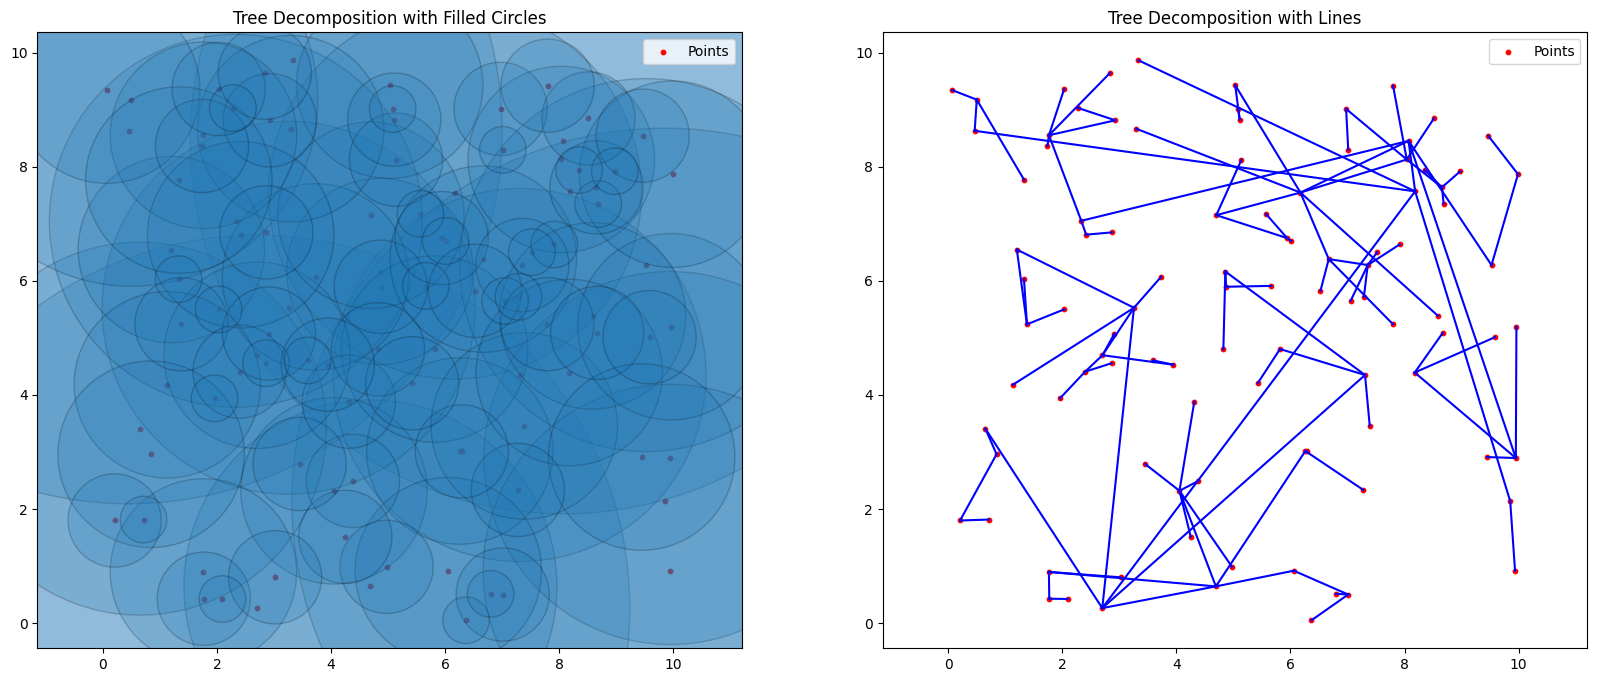

In [6]:
# some random data
points = np.unique(np.random.uniform(0, 10, (100, 2)), axis=0)

my_tree = Tree(points)
visualize(my_tree)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None


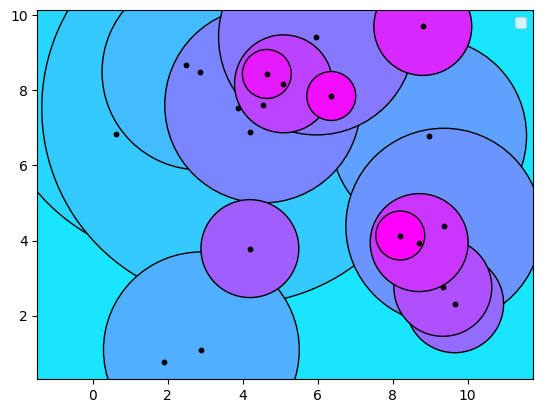

In [39]:
def draw_circles(tree):
    colormap = plt.cm.cool
    colors = [colormap(i) for i in np.linspace(0, 1, len(tree.nodes))]
    
    fig, ax = plt.subplots()
    circles = [plt.Circle(tree.points[node.point_id], node.radius, facecolor=colors[i], edgecolor='black') for i, node in enumerate(tree.nodes)]
    # np.random.shuffle(circles)
    for circle in circles:
        ax.add_artist(circle)
    ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.scatter(tree.points[:, 0], tree.points[:, 1], s=10, color='black', label='Points')
    plt.show()


small_sample = np.unique(np.random.uniform(0, 10, (20, 2)), axis=0)
small_tree = Tree(small_sample)
draw_circles(small_tree)

In [8]:
def visualize_labels(tree):
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(tree.sequence[:, 0], tree.sequence[:, 1], s=10, c=tree.labels, cmap='viridis')
    legend1 = ax.legend(*scatter.legend_elements(), title="Labels")
    ax.add_artist(legend1)
    for node in tree.nodes:
        if node.parent:
            ax.plot([tree.sequence[node.point_id][0], tree.sequence[node.parent.point_id][0]], 
                    [tree.sequence[node.point_id][1], tree.sequence[node.parent.point_id][1]], 
                    color='blue')

    ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.set_title("Tree Decomposition with Lines")
    plt.show()

In [9]:
iris = datasets.load_iris()
irisX = np.unique(iris.data[:, 2:4], axis=0)
irisY = iris.target[np.unique(iris.data[:, 2:4], axis=0, return_index=True)[1]]
# irisX = iris.data[:, 2:4]
# irisY = iris.target

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


None


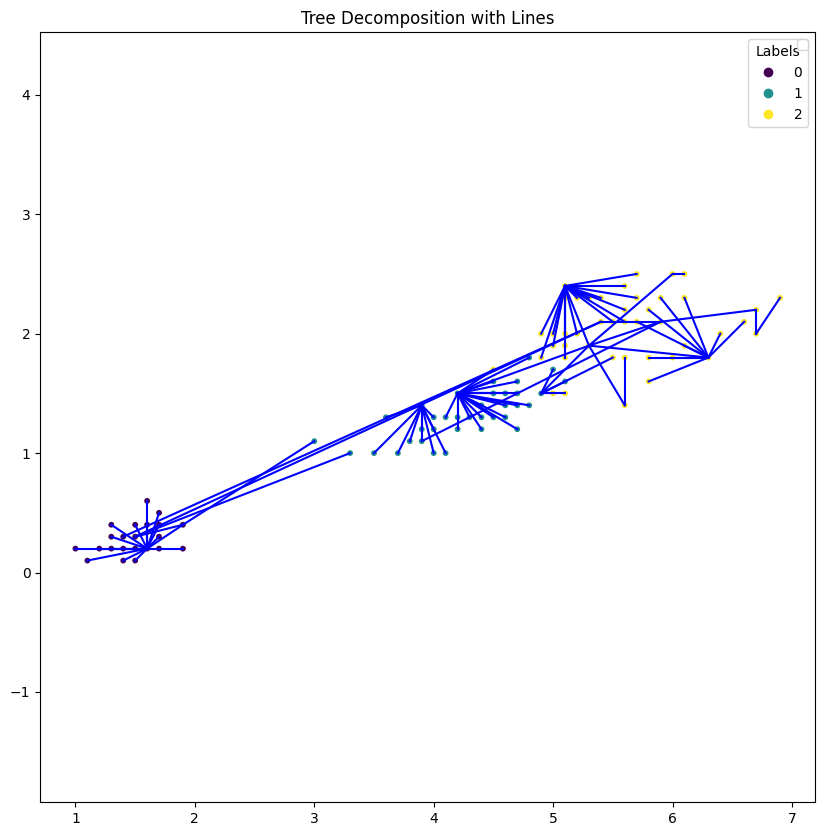

In [10]:
iris_tree = Tree(irisX, irisY)
visualize_labels(iris_tree)

In [11]:
def visualiza_3d(tree):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tree.sequence[:, 0], tree.sequence[:, 1], tree.sequence[:, 2], s=10, color='red', label='Points')
    for node in tree.nodes:
        if node.parent:
            ax.plot([tree.sequence[node.point_id][0], tree.sequence[node.parent.point_id][0]], 
                    [tree.sequence[node.point_id][1], tree.sequence[node.parent.point_id][1]],
                    [tree.sequence[node.point_id][2], tree.sequence[node.parent.point_id][2]], 
                    color='blue')
    ax.view_init(elev=10, azim=40)
    ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    ax.set_title("Tree Decomposition with Lines")
    plt.show()

None


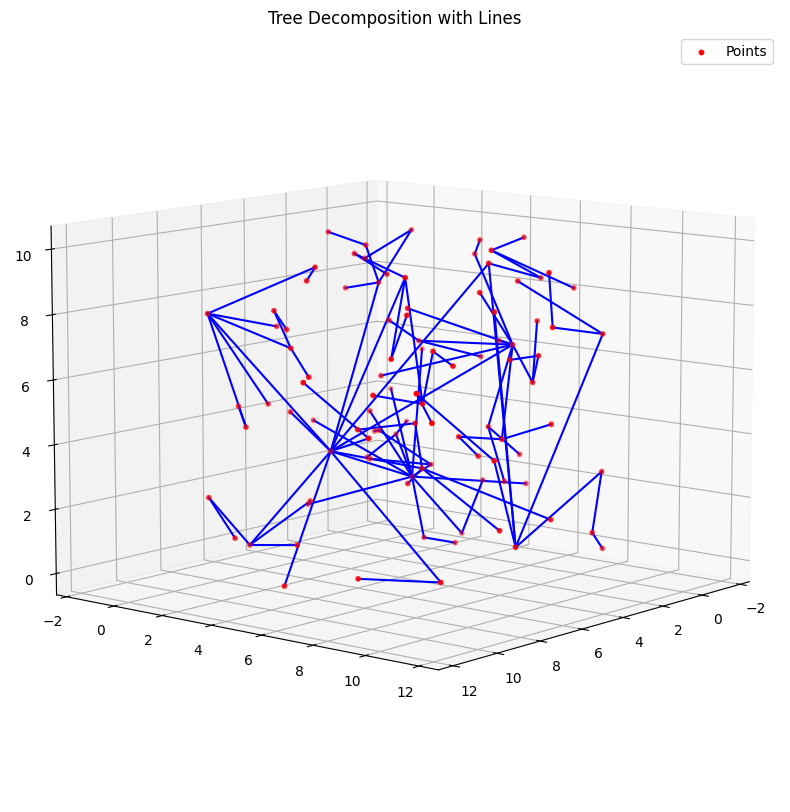

In [12]:
points3d = np.unique(np.random.uniform(0, 10, (100, 3)), axis=0)
my_tree = Tree(points3d)
visualiza_3d(my_tree)